# Evolving Convnets to Reconstruct Depth Images

In [1]:
%matplotlib inline
from __future__ import print_function
import gc
import ipywidgets
import math
import os
import random
import sys

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import Image
from scipy import ndimage
from scipy.misc import imsave

import outputer
import improc
import convnet
import mutate
import convevo
import darwin

In [ ]:
reload (improc)
reload (convnet)
reload (mutate)
reload (convevo)
reload (darwin)

# Enumerate Images
Image names are sequential, so add every tenth image to the validation set based on filename.

In [2]:
training, test = improc.enumerate_images("captures")

print("Training:", len(training), "Test:", len(test))
print(training[:2])
print(test[:2])

Training: 10113 Test: 1123
['captures/attitude/5000-6000/cap - 5735.PNG', 'captures/attitude/5000-6000/cap - 5252.PNG']
['captures/attitude/5000-6000/cap - 5360.PNG', 'captures/attitude/5000-6000/cap - 5870.PNG']


# Image Processing
Each image file contains a color image (top half), and an encoded depth image (bottom half)
<img src="testing/IMG_2114.PNG">
* Note: The image may also contain the orientation data. If so it is encoded in the first two pixels of the depth image. If the first pixel of the depth image is red, the second has the x, y, z, w quaternion components encoded in the r,g,b,a values.

The improc module contains functions for splitting the image, decoding the depth back into floating point millimeters, and for filling in gaps.

In [3]:
# Precomputed via compute_average_depth()
# Actually it should 1680.24, value below is actually the mean of the image means.
# Keeping this value as it was what was used in the experiments to date,
# and it is close to the correct value.
MEAN_DEPTH = np.float32(1688.97)
NORMALIZED_MEAN_DEPTH = MEAN_DEPTH / improc.MAX_DEPTH

print(MEAN_DEPTH)

1688.97


In [4]:
depth_image_cache_path = outputer.setup_directory("temp", "cache")

class ImageSampler(object):
    """Wrap an image for sampling."""
    def __init__(self, image_file, make_holes, zero_mean=False):
        # Process the image or grab it from the cache.
        # image is normalized CIELAB, depth is not normalized.
        self.image, self.depth = improc.process_cached(depth_image_cache_path, image_file)
        self.depth /= improc.MAX_DEPTH
        self.make_holes = make_holes
        self.mean_offset = 0
        if zero_mean:
            self.mean_offset = NORMALIZED_MEAN_DEPTH
            self.depth -= self.mean_offset
            
    def scale_size(self, size, pixel_count):
        return int(size * pixel_count / 100.0)
        
    def make_hole_mask(self, image_slot, entropy, bias=-0.15, noise_scales=None):
        mask_height = image_slot.shape[0] 
        mask_width = image_slot.shape[1]
        if not noise_scales:
            noise_scales = [
                (self.scale_size(2, mask_height), self.scale_size(2, mask_width), 0.6),
                (self.scale_size(40, mask_height), self.scale_size(20, mask_width), .35),
                (mask_height / 2, mask_width / 2, 0.05)
            ]
        noise_image = np.zeros(shape=(image_slot.shape[:2]))
        for y_scale, x_scale, amplitude in noise_scales:
            noise_image += improc.make_noise(
                mask_height, mask_width, y_scale, x_scale, entropy
            ) * amplitude
        return noise_image, noise_image > bias

    def sample(self, image_slot, depth_slot,
               mask_slot=None, h_offset=None, w_offset=None, entropy=np.random):
        height = image_slot.shape[0]
        spare_height = self.image.shape[0] - height
        y = spare_height / 2 if h_offset is None else h_offset
        
        width = image_slot.shape[1]
        spare_width = self.image.shape[1] - width
        x = spare_width / 2 if w_offset is None else w_offset
        
        if self.make_holes:
            input_depth = image_slot[:,:,-1]
            input_depth[:,:] = improc.mipmap_imputer(
                self.depth[y : y + height, x : x + width], smooth=True
            )
            _, mask = self.make_hole_mask(input_depth, entropy)
            input_depth[np.where(mask)] = -1
            image_slot = image_slot[:,:,:-1]
            if mask_slot is not None:
                mask_slot[:,:,0] = mask
        else:
            image_slot = image_slot[:,:,:]
        
        image_slot[:,:,:] = self.image[y : y+height, x : x+width, : image_slot.shape[-1]]
        depth_slot[:,:,0] = self.depth[y : y+height, x : x+width]

In [5]:
def prepare_images(paths, inputs, targets, masks=None, entropy=np.random):
    for i, sampler in enumerate([ImageSampler(path, masks is not None) for path in paths]):
        sampler.sample(inputs[i], targets[i],
                       None if masks is None else masks[i], entropy=entropy)

## Image processing examples

In [ ]:
example_image, example_depth, example_attitude = improc.load_image("testing/IMG_2114.PNG")
plt.imshow(example_image)
print(example_image.shape, example_image.dtype)

In [ ]:
plt.imshow(example_depth)
print(example_depth.shape, example_depth.dtype)
print(example_attitude)

In [ ]:
sampler = ImageSampler("testing/IMG_2114.PNG", False)
sample_size = 100
image_sample = np.zeros(shape=(sample_size, sample_size, 3))
depth_sample = np.zeros(shape=(sample_size, sample_size, 1))
sampler.sample(image_sample, depth_sample)

print(image_sample.shape, image_sample.dtype)
plt.imshow(image_sample)

In [ ]:
plt.imshow(depth_sample.reshape(sample_size, sample_size))
print(depth_sample.shape, depth_sample.dtype)
print(np.min(depth_sample), np.max(depth_sample))

In [ ]:
sampler = ImageSampler("testing/IMG_2114.PNG", True)
sample_size = 100
image_sample = np.zeros(shape=(sample_size, sample_size, 4))
depth_sample = np.zeros(shape=(sample_size, sample_size, 1))
sample_mask = np.zeros(shape=(sample_size, sample_size, 1))
sampler.sample(image_sample, depth_sample, sample_mask, entropy=np.random.RandomState(11))

print(image_sample.shape, image_sample.dtype)
plt.imshow(image_sample[:,:,-1])

In [ ]:
plt.imshow(sample_mask[:,:,0])
print(np.sum(sample_mask) / np.sum(np.ones_like(sample_mask)))

# Data Management

In [6]:
COLOR_CHANNELS = 3
image_height = 480
image_width = 640

data_files = {
    "image_size": (image_height, image_width, COLOR_CHANNELS),
    "depth_size": (image_height, image_width, 1),
    "train_files": np.array(sorted(training)),
    "test_files": np.array(sorted(test))
}

del training
del test

In [7]:
def setup_cross_validation(
    data, valid_count, test_count=None, chunk_size=None, entropy=random
):
    cross_data = data.copy()
    
    if chunk_size:
        cross_data["image_size"] = chunk_size
        cross_data["depth_size"] = chunk_size[:-1] + (1,)

    paths = cross_data["train_files"][:]
    mutate.fisher_yates_shuffle(paths, entropy)

    cross_data["train_files"] = paths[:-valid_count]
    cross_data["valid_files"] = paths[-valid_count:]
    
    if test_count is None:
        del cross_data["test_files"]
    else:
        cross_data["test_files"] = data["test_files"][:test_count]
    
    return cross_data

# Graph Setup

In [8]:
def setup_graph(
    batch_size,
    image_shape,
    target_shape,
    stack
):
    graph = tf.Graph()
    with graph.as_default():
        input_shape = (batch_size,) + image_shape
        output_shape = (batch_size,) + target_shape
        train   = tf.placeholder(tf.float32, shape=input_shape)
        targets = tf.placeholder(tf.float32, shape=output_shape)
        verify  = tf.placeholder(tf.float32, shape=input_shape)

        operations = stack.construct(input_shape, output_shape)
        l2_loss = convnet.setup(operations)
        
        results = convnet.connect_model(train, operations, True)[-1]
        
        # Fill NaNs in target with values from results to
        # eliminate any contribution to the gradient
        valid_targets = tf.select(tf.is_nan(targets), results, targets)
        
        loss = tf.reduce_mean(tf.squared_difference(results, valid_targets)) + l2_loss
        
        verify_predictions = convnet.connect_model(verify, operations, False)[-1]
        verify_predictions = tf.maximum(verify_predictions, 0)
        verify_predictions = tf.minimum(verify_predictions, 1)
        
        info = {
            "graph": graph,
            "batch_size": batch_size,
            "train": train,
            "targets": targets,
            "loss": loss,
            "optimizer": stack.construct_optimizer(loss),
            "predictions": results,
            "verify": verify,
            "verify_predictions": verify_predictions,
            "saver": tf.train.Saver()
        }
    return info

# Graph Execution

In [9]:
def prediction_error(predictions, targets):
    is_finite = np.isfinite(targets)
    where_valid = np.where(is_finite)
    error = np.mean(np.absolute(predictions[where_valid] - targets[where_valid]))
    return error, np.count_nonzero(is_finite)

In [10]:
def make_predictor(session, graph_info):
    def predict(inputs, targets):
        feed_dict = {graph_info["verify"]: inputs}
        return session.run([graph_info["verify_predictions"]], feed_dict=feed_dict)[0]
    return predict

In [11]:
def mask_targets(targets, masks):
    if masks is not None:
        targets[np.where(np.logical_not(masks))] = np.nan

In [12]:
def batch_prediction_error(
    predictor, files, inputs, targets, masks, batch_size, entropy=np.random
):
    total_error = 0
    total_count = 0
    batch_count = len(files) / batch_size
    for b in xrange(batch_count):
        offset = b * batch_size
        end = offset + batch_size
        prepare_images(files[offset:end], inputs, targets, masks, entropy)
        predictions = predictor(inputs, targets)
        mask_targets(targets, masks)
        error, count = prediction_error(predictions, targets)
        total_error += error * count
        total_count += count
    return (total_error / np.float32(total_count)), predictions, targets

In [13]:
def depth_mean_like(depths):
    return np.ones_like(depths) * (MEAN_DEPTH / improc.MAX_DEPTH)

def always_guess_mean_error(files, inputs, targets, masks, batch_size, entropy):
    def predict_mean(images, depths):
        return depth_mean_like(depths)
    return batch_prediction_error(
        predict_mean,
        files, inputs,
        targets, masks,
        batch_size, entropy
    )[0]

In [14]:
def batch_input_shape(batch_size, data, make_holes):
    shape = (batch_size,) + data["image_size"]
    if make_holes:
        shape = shape[:-1] + (shape[-1] + 1,)
    return shape

def batch_output_shape(batch_size, data):
    return (batch_size,) + data["depth_size"]

def score_run(guess_mean_error, valid_error):
    return guess_mean_error - min(valid_error, 1)

def run_graph(
    graph_info,
    data,
    make_holes,
    step_count,
    report_every=50,
    verbose=True,
    tracker=None,
    track_minibatch_error=False,
    mean_error_cache=None,
    error_maximum=None,
    prepare_seeds=None
):
    with tf.Session(graph=graph_info["graph"]) as session:
        tf.initialize_all_variables().run()
        print("Initialized")

        # Optionally restore graph parameters from disk.
        convnet.restore_model(graph_info, session)
        
        batch_size = graph_info["batch_size"]
        batch_inputs = np.empty(shape=batch_input_shape(batch_size, data, make_holes),
                                dtype=np.float32)
        batch_targets = np.empty(shape=batch_output_shape(batch_size, data),
                                 dtype=np.float32)
        if make_holes:
            batch_masks = np.empty(shape=batch_targets.shape, dtype=np.bool)
        else:
            batch_masks = None

        # Validation and scoring bits.
        valid_error = 1
        if prepare_seeds is None:
            prepare_seeds = [random.randint(1, 12345), random.randint(1, 12345)]
        
        guess_mean_error = None
        if mean_error_cache is not None:
            guess_mean_error = mean_error_cache.get("cached")
        if not guess_mean_error:
            guess_mean_error = always_guess_mean_error(
                data["valid_files"], batch_inputs, batch_targets, batch_masks, batch_size,
                np.random.RandomState(prepare_seeds[1])
            )
            print("Error if just guess mean:", guess_mean_error)
            
            if mean_error_cache is not None:
                mean_error_cache["cached"] = guess_mean_error
        predictor = make_predictor(session, graph_info)
        prepare_entropy = np.random.RandomState(prepare_seeds[0])
        
        training_files = data["train_files"]
        try:
            for step in xrange(step_count + 1):
                if tracker:
                    tracker.update_progress(step)

                # Generate a minibatch.
                offset = (step * batch_size) % (training_files.shape[0] - batch_size)
                batch_files = training_files[offset:(offset + batch_size)]
                prepare_images(
                    batch_files, batch_inputs, batch_targets, batch_masks, prepare_entropy
                )

                # Graph evaluation targets:
                targets = [
                    graph_info["optimizer"],
                    graph_info["loss"],
                    graph_info["predictions"]
                ]
                
                # Graph inputs:
                feed_dict = {
                    graph_info["train"] : batch_inputs,
                    graph_info["targets"] : batch_targets
                }
                
                # Run the graph
                _, loss, predictions = session.run(targets, feed_dict=feed_dict)
                
                # Capture last prediction
                results = (predictions[-1], batch_targets[-1], batch_inputs[-1])
                
                # Update stats:
                reporting = step % report_every == 0
                if reporting or track_minibatch_error:
                    batch_error, _ = prediction_error(predictions, batch_targets)
                else:
                    batch_error = None
                if tracker:
                    tracker.record_score((loss, batch_error))
                
                if not np.isfinite(loss):
                    print("Error computing loss:", loss)
                    print(np.sum(np.isnan(predictions)))
                    return score_run(guess_mean_error, valid_error), results
                
                if reporting:
                    if verbose:
                        print("Minibatch loss at step", step, ":", loss)
                        print("Minibatch error:", batch_error)
                    valid_error, _, _ = batch_prediction_error(
                        predictor, data["valid_files"],
                        batch_inputs, batch_targets, batch_masks, batch_size,
                        np.random.RandomState(prepare_seeds[1])
                    )
                    print("Validation error:", valid_error)
                    if error_maximum and step > 0 and valid_error > error_maximum:
                        print("Early out.")
                        break
            test_files = data.get("test_files")
            if test_files is not None:
                test_results = batch_prediction_error(
                    predictor, test_files,
                    batch_inputs, batch_targets, batch_masks, batch_size,
                    np.random.RandomState(prepare_seeds[1])
                )
                print("Test error:", test_results[0])
                results = results + test_results
            return score_run(guess_mean_error, valid_error), results
        finally:
            # Optionally save out graph parameters to disk.
            convnet.save_model(graph_info, session)

## Testing Error Metrics

In [21]:
TEST_BATCH = 1
test_inputs = np.empty(shape=(TEST_BATCH, 480, 640, COLOR_CHANNELS + 1), dtype=np.float32)
test_depths = np.empty_like(test_inputs[:,:,:,:1])
test_mask = np.empty_like(test_depths)
prepare_images(data_files["test_files"][:TEST_BATCH], test_inputs, test_depths, test_mask,
               np.random.RandomState(1))

-0.966718 0.999503
-0.175679 0.303895
-0.316126 0.528954


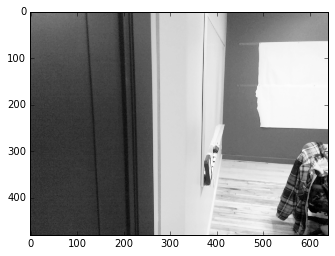

In [22]:
plt.imshow(test_inputs[0,:,:,0], cmap='Greys_r')
print(np.min(test_inputs[0,:,:,0]),np.max(test_inputs[0,:,:,0]))
print(np.min(test_inputs[0,:,:,1]),np.max(test_inputs[0,:,:,1]))
print(np.min(test_inputs[0,:,:,2]),np.max(test_inputs[0,:,:,2]))

0.0326417 0.316802


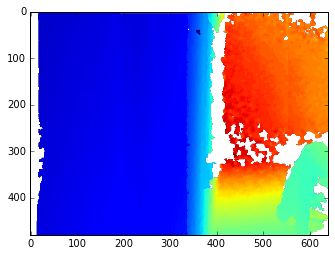

In [23]:
plt.imshow(test_depths[0,:,:,0])
depths_valid = np.where(np.isfinite(test_depths[0]))
print(np.min(test_depths[0][depths_valid]),np.max(test_depths[0][depths_valid]))

In [24]:
print(test_inputs.shape)
print(test_depths.shape)
prediction_error(test_inputs[:,:,:,0:1], test_depths)

(1, 480, 640, 4)
(1, 480, 640, 1)


(0.54593152, 275828)

In [25]:
prediction_error(np.zeros_like(test_depths), test_depths)

(0.12910527, 275828)

In [26]:
prediction_error(depth_mean_like(test_depths), test_depths)

(0.074445941, 275828)

In [27]:
prediction_error(test_depths, test_depths)

(0.0, 275828)

In [28]:
mask_targets(test_depths, test_mask)
prediction_error(depth_mean_like(test_depths), test_depths)

(0.074546993, 230583)

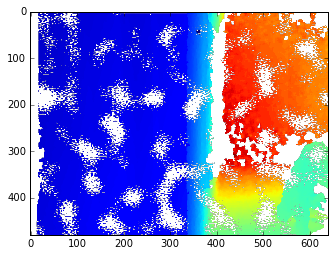

In [29]:
plt.imshow(test_depths[0,:,:,0])

## Testing components

In [30]:
TEST_BATCH = 1
MAKE_HOLES = True
conv_layers = [
    ("conv",       5, 2, 10, "SAME", False),
    ("conv",      10, 2, 20, "SAME", False),
    ("conv_bias", 15, 5, 25, "SAME", False)
]
expand_layers = [
    (5, 5, "SAME", True, False),
    (2, 5, "SAME", True, False),
    (2, 5, "SAME", True, False)
]
test_input_shape = batch_input_shape(TEST_BATCH, data_files, MAKE_HOLES)
test_output_shape = batch_output_shape(TEST_BATCH, data_files)
test_stack = convevo.create_stack(conv_layers, expand_layers, False, [], 0.0, 0.01, 0.0)
test_stack.make_safe(test_input_shape, test_output_shape)
test_stack.reseed(random.Random(24601))

In [31]:
sample_size = data_files["image_size"]
depth_size = data_files["depth_size"]

test_graph = setup_graph(TEST_BATCH, test_input_shape[1:], depth_size, test_stack)

In [32]:
test_cross = setup_cross_validation(data_files, 200, 200, sample_size)
test_score, test_results = run_graph(
    test_graph, test_cross, MAKE_HOLES, 8, 4, True, prepare_seeds=[654, 321]
)
print(test_score)

Initialized
Error if just guess mean: 0.0404833101656
Minibatch loss at step 0 : 0.00512018
Minibatch error: 0.0718255
Validation error: 0.103808982969
Minibatch loss at step 4 : 0.0087311
Minibatch error: 0.0925523
Validation error: 0.0966058260331
Minibatch loss at step 8 : 0.0168169
Minibatch error: 0.1196
Validation error: 0.0855628193431
Test error: 0.091100114908
-0.0450795091775


In [ ]:
plt.imshow(test_results[0][:,:,0])
print(np.min(test_results[0]),np.max(test_results[0]))

In [ ]:
plt.imshow(test_results[1].reshape(sample_size[0],sample_size[1]))

In [ ]:
plt.imshow(test_results[2][:,:,0], cmap='Greys_r')

In [ ]:
del test_stack
del test_graph
del test_cross
del test_results
gc.collect()

# Evolving

In [15]:
results_path = outputer.setup_directory("temp", "pyndent_results")

In [16]:
def make_eval(batch_size, eval_steps, valid_size, reuse_cross, make_holes, entropy=random):
    mean_error_cache = None
    if reuse_cross:
        redata = setup_cross_validation(
            data_files, valid_size, entropy=entropy
        )
        mean_error_cache = {}

    progress_tracker = outputer.ProgressTracker(
        ["Loss", "Error"], eval_steps, results_path, convevo.serialize
    )
    
    prepare_seeds = [random.randint(1, 12345), random.randint(1, 12345)]

    def evaluate(stack, eval_entropy):
        # If not reusing data, generate training and validation sets
        if not reuse_cross:
            data = setup_cross_validation(
                data_files, valid_size, entropy=eval_entropy
            )
        else:
            data = redata
       
        progress_tracker.setup_eval(stack)

        # Set up the graph
        try:
            graph_info = setup_graph(
                batch_size,
                batch_input_shape(batch_size, data, make_holes)[1:],
                data["depth_size"],
                stack
            )
        except KeyboardInterrupt:
            raise
        except:
            progress_tracker.error(sys.exc_info())
            return -10

        progress_tracker.start_eval(graph_info)
                
        # Run the graph
        try:
            valid_error, _ = run_graph(
                graph_info,
                data,
                make_holes,
                eval_steps,
                report_every=eval_steps/10,
                verbose=True,
                tracker=progress_tracker,
                mean_error_cache=mean_error_cache,
                error_maximum=None,
                prepare_seeds=prepare_seeds
            )
            return valid_error
        except KeyboardInterrupt:
            raise
        except:
            progress_tracker.error(sys.exc_info())
            return -1
        finally:
            progress_tracker.output()
    return evaluate

# Specific Evolutionary Experiments
Only run one of the following. In the case of the hole filling, also set **make_holes** to True in the **Evolve!** section.

In [ ]:
# Basic convolutional network.
conv_layers = [
    ("conv",       5, 2, 10, "SAME", False),
    ("conv",      10, 2, 20, "SAME", False),
    ("conv_bias", 15, 5, 25, "SAME", False)
]
expand_layers = [
    (5, 5, "SAME", True, False),
    (2, 5, "SAME", True, False),
    (2, 5, "SAME", True, False)
]
prototype = convevo.create_stack(conv_layers, expand_layers, False, [], 0.0, 0.01, 0.0)

prototypes = [prototype]

In [ ]:
# Past evolutionary experiment
population,_,_ = convevo.load_population("testing/pyndent_evolve_run.xml", False)
prototypes = population[:5]
print(len(prototypes))

In [ ]:
# Hand selected/tuned protototypes
prototypes = [
    convevo.load_stack("testing/pyndent1.xml"),
    convevo.load_stack("testing/pyndent2.xml"),
    convevo.load_stack("testing/pyndent3.xml"),
    convevo.load_stack("testing/pyndent4.xml"),
    convevo.load_stack("testing/pyndent5.xml")
]

In [17]:
# Evoloved prototype
prototypes = [
    convevo.load_stack("testing/pyndent6/2016-06-22~17_51_16_872.xml")
]

In [ ]:
# Hole filling variant experiments
prototypes = [
    convevo.load_stack("testing/passthrough.xml")
    convevo.load_stack("testing/holes1.xml")
]

# Evolve!

In [18]:
with outputer.TeeOutput(os.path.join("temp", outputer.timestamp("Pyndent_evo", "txt"))):
    mutate_seed = random.randint(1, 100000)
    print("Mutate Seed:", mutate_seed)
    mutate_entropy = random.Random(mutate_seed)
    eval_seed = random.randint(1, 100000)
    print("Eval Seed:", eval_seed)
    eval_entropy = random.Random(eval_seed)

    population_size = 10
    generations = 5
    batch_size = 1
    make_holes = False

    breed_options = {
        "input_shape": batch_input_shape(batch_size, data_files, make_holes),
        "output_shape": batch_output_shape(batch_size, data_files),
        "fixed_stride": make_holes,
        "fixed_padding": make_holes
    }

    # Ensure loaded networks match input/output shapes for this run
    for stack in prototypes:
        stack.make_safe(breed_options["input_shape"], breed_options["output_shape"])

    evaluator = make_eval(
        batch_size=batch_size, eval_steps=80000, valid_size=400,
        reuse_cross=True, make_holes=make_holes, entropy=eval_entropy
    )
    charles = darwin.Darwin(convevo.serialize, evaluator, convevo.breed)
    charles.init_population(
        prototypes, population_size, True, breed_options, mutate_entropy
    )

    try:
        for g in range(generations):
            print("Generation", g)
            results = charles.evaluate(eval_entropy)
            convevo.output_results(
                results, "temp", outputer.timestamp() + ".xml", mutate_seed, eval_seed
            )
            charles.repopulate(
                population_size, 0.3, 3, results, breed_options, mutate_entropy
            )
    finally:
        results = darwin.descending_score(charles.history.values())
        convevo.output_results(results, "temp", "pyndent_evo.xml", mutate_seed,eval_seed)
        print("Evaluated", len(results))

Mutate Seed: 44051
Eval Seed: 78895
Generation 0
Evaluating 0
Initialized
Error if just guess mean: 0.04063897228
Minibatch loss at step 0 : 189087.0
Minibatch error: 0.0568784
Validation error: 0.139847270129
Minibatch loss at step 8000 : 1.1724
Minibatch error: 0.0681716
Validation error: 0.103052902502
Minibatch loss at step 16000 : 0.0457544
Minibatch error: 0.245856
Validation error: 0.10252967764
Minibatch loss at step 24000 : 0.0148674
Minibatch error: 0.112716
Validation error: 0.0939765396165
Minibatch loss at step 32000 : 0.0540595
Minibatch error: 0.211928
Validation error: 0.0591228422401
Minibatch loss at step 40000 : 0.00297333
Minibatch error: 0.0522493
Validation error: 0.0400396577946
Minibatch loss at step 48000 : 0.0023768
Minibatch error: 0.0349519
Validation error: 0.0409247713305
Minibatch loss at step 56000 : 0.00202459
Minibatch error: 0.041389
Validation error: 0.0400688468103
Minibatch loss at step 64000 : 0.00288671
Minibatch error: 0.0545204
Validation error

KeyboardInterrupt: 

# Candidate Test Evaluation

In [19]:
def compute_test_images(graph_info, data, make_holes, output_path, entropy):
    with tf.Session(graph=graph_info["graph"]) as session:
        tf.initialize_all_variables().run()
        print("Initialized")

        # restore graph parameters from disk.
        convnet.restore_model(graph_info, session)
        
        # Set up space for graph inputs
        batch_size = graph_info["batch_size"]
        batch_inputs = np.empty(shape=batch_input_shape(batch_size, data, make_holes),
                                dtype=np.float32)
        batch_targets = np.empty(shape=batch_output_shape(batch_size, data),
                                 dtype=np.float32)
        batch_masks = None
        if make_holes:
            batch_masks = np.empty(shape=batch_targets.shape, dtype=np.bool)

        predictor = make_predictor(session, graph_info)

        # Set up progress bar
        test_files = data["test_files"]
        eval_count = len(test_files) / batch_size
        progress = outputer.show_progress("Evaluation Steps:", eval_count)
        
        # Only score error on same portion of the image as classy so we can compare.
        input_image_size = batch_inputs.shape[1:]
        classy_sample = (101, 101)
        sample_start = tuple(cs / 2 for cs in classy_sample)
        sample_end = tuple(
            ss+iis-cs for ss,iis,cs in zip(sample_start, input_image_size, classy_sample)
        )
        classy_depth_start = (input_image_size[0] + sample_start[0], sample_start[1])
        classy_depth_end = tuple(
             cds+se-ss for cds,se,ss in zip(classy_depth_start, sample_end, sample_start)
        )
        def sample_patch(image, index):
            return image[
                index,
                sample_start[0] : sample_end[0],
                sample_start[1] : sample_end[1],
                :
            ]
        
        titles = ["Name", "Error", "Count"]
        print(",".join(titles))
        
        all_scores = []
        error_sum = 0
        pixel_count = 0
        for step in xrange(eval_count):            
            progress.value = step # Update progress bar
            
            # Load the test data and calculate predicted depths.
            offset = step * batch_size
            end = offset + batch_size
            batch_files = test_files[offset:end]
            prepare_images(batch_files, batch_inputs, batch_targets, batch_masks)
            predictions = predictor(batch_inputs, batch_targets)
            mask_targets(batch_targets, batch_masks)

            for i in xrange(batch_size):
                image_path = batch_files[i]
                image_name, ext = os.path.splitext(os.path.basename(image_path))

                # Calculate metrics
                error, count = prediction_error(
                    sample_patch(predictions, i), sample_patch(batch_targets, i)
                )
                results = [image_name, error, count]
                error_sum += error * count
                pixel_count += count
                all_scores.append(results)
        
                # Encode result images
                image = ndimage.imread(image_path)
                encoded_depths = improc.encode_normalized_depths(predictions)

                # Classy patch
                image[
                    classy_depth_start[0] : classy_depth_end[0],
                    classy_depth_start[1] : classy_depth_end[1],
                    :
                ] = sample_patch(encoded_depths, i)
                imsave(os.path.join(output_path, image_name + "_framed.png"), image)
                
                # Full image
                image[input_image_size[0]:,:,:] = encoded_depths[i]
                imsave(os.path.join(output_path, image_name + "_full.png"), image)
                
                print(",".join(str(v) for v in results))

        # Aggregate results
        print(",".join(["Total", str(error_sum / pixel_count), str(pixel_count)]))
              
        sorted_scores = sorted(all_scores, key=lambda l: l[1])
        print(titles[1] + " high")
        print(",".join([str(v) for v in sorted_scores[-1]]))
        print(titles[1] + " low")
        print(",".join([str(v) for v in sorted_scores[0]]))
              
        return all_scores

In [20]:
test_results_path = outputer.setup_directory("temp/pyndent6")
BATCH_SIZE = 1
MAKE_HOLES = False

with outputer.TeeOutput(os.path.join(test_results_path, "test_results.txt")):
    candidate = convevo.load_stack(
        "testing/pyndent6/2016-07-15~20_30_58_640.xml"
    )
    test_data = setup_cross_validation(
        data_files, 0, 1123, entropy=random.Random(121)
    )
    test_input_shape = batch_input_shape(BATCH_SIZE, test_data, MAKE_HOLES)
    candidate_graph = setup_graph(
        BATCH_SIZE, test_input_shape[1:], test_data["depth_size"], candidate
    )
    convnet.setup_restore_model(
        candidate_graph, candidate.checkpoint_path()
    )
    candidate_test_scores = compute_test_images(
        candidate_graph, test_data, MAKE_HOLES, test_results_path, random.Random(57)
    )

Initialized
Restored model from temp/pyndent_results/2016-07-15~20_30_58_640.ckpt
Name,Error,Count
cap - 10,0.0756236,189845
cap - 100,0.0572637,200965
cap - 110,0.0626924,198938
cap - 120,0.0405665,188894
cap - 130,0.064621,186506
cap - 140,0.016785,202139
cap - 150,0.0232162,197936
cap - 160,0.0276846,201475
cap - 170,0.0184272,201771
cap - 180,0.0318021,166816
cap - 190,0.0228608,193995
cap - 20,0.07667,181704
cap - 200,0.0448921,202440
cap - 210,0.0819304,175337
cap - 220,0.0402337,183099
cap - 230,0.0355303,204281
cap - 240,0.041141,189099
cap - 250,0.0687856,203039
cap - 260,0.0617816,203352
cap - 270,0.0499299,203935
cap - 280,0.0521542,203963
cap - 290,0.0276152,198196
cap - 30,0.046477,196248
cap - 300,0.0628451,194720
cap - 310,0.0463433,188700
cap - 320,0.0921699,164011
cap - 330,0.0271105,195085
cap - 340,0.0336599,204281
cap - 350,0.015971,201305
cap - 360,0.0386402,189008
cap - 370,0.0131716,178002
cap - 380,0.0430353,201567
cap - 390,0.059494,203941
cap - 40,0.0513359,18